In [27]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift
from data.fortran_test.utils import get_predictions, plot_vofs, create_plot
from src.ml.building import custom_loss

In [29]:
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift, Edge
import subprocess
import re

# Suppress tensorflow logging
import logging
import os
from itertools import product as itpd
from multiprocessing import Process

# import threading
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

st_sz = [5, 5]

files = [
f'./data_CVOFLS_128_0012003_{st_sz[0]}x{st_sz[1]}.feather',
f'./data_CVOFLS_256_0010033_{st_sz[0]}x{st_sz[1]}.feather',
f'./data_CVOFLS_32_0010033_{st_sz[0]}x{st_sz[1]}.feather',
f'./data_CVOFLS_128_00160028_{st_sz[0]}x{st_sz[1]}.feather',
f'./data_CVOFLS_128_0010033_{st_sz[0]}x{st_sz[1]}.feather',
f'./data_CVOFLS_64_0010033_{st_sz[0]}x{st_sz[1]}.feather',
]

files_dict = {}

for filename in files:
    if not ('file' in locals()):
        file = pd.read_feather(filename)
        print(f'Shape:\t{file.shape}')
    else:
        file = file.append(pd.read_feather(filename), ignore_index=True)
        print(f'Shape:\t{file.shape}')

Shape:	(12606493, 26)
Shape:	(13513308, 26)
Shape:	(13960664, 26)
Shape:	(16222472, 26)
Shape:	(18116263, 26)
Shape:	(19058958, 26)


In [30]:
tmp = data[data[:, 0] < 0]
print(tmp.shape)

(0, 26)


In [31]:
parameters = {'stencil_size': st_sz, 'angle': False}
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    #('shift', Shift(parameters=parameters)),  # Output: [labels, data, angle_matrix]
    ('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
    #('edge', Edge(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
])
[lab, feat, ang] = data_pipeline.fit_transform(file)

In [32]:
# Get random values
np.random.seed(6) 
indices = np.random.permutation(feat.shape[0])

features = feat[indices, :]
labels = lab[indices]#*0.075/128

In [33]:
#model = '_mlp_1000_200-150-120_7x7_rot_flp_cut_dshift1_shift1_nbi_6'
#predictions = get_predictions(features, basepath=basepath, filename=model)#*faktor  # vector_last*faktor # 

CVOFLS: [0.025 0.032 0.03  0.023 0.051 0.176 0.028 0.03  0.026 0.03 ]



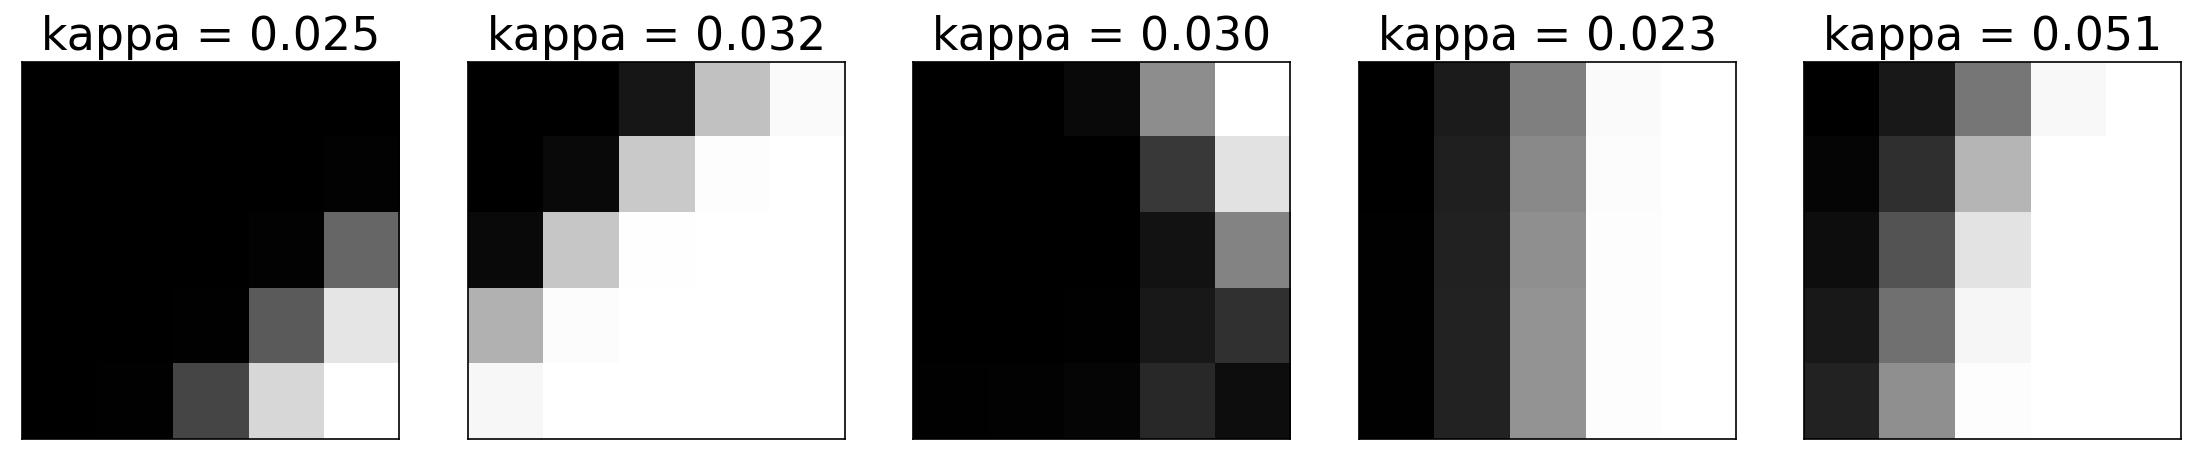

In [34]:
#print(f'Predictions: {np.round(predictions[:10], 3)}')
print(f'CVOFLS: {np.round(labels[:10], 3)}')
    
n_plots = 5
plot_vofs(np.reshape(features, (features.shape[0],st_sz[0],st_sz[1])), n_plots, per_row=5, labels=labels)

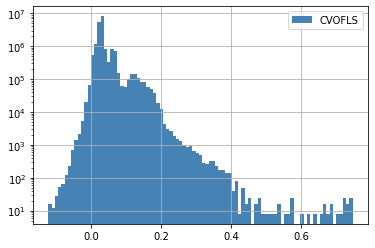

In [69]:
roud = 3

pd.Series(np.round(labels, roud)).hist(bins=93, color='steelblue', label='CVOFLS')
ax = plt.gca()
ax.set_yscale('log')
plt.legend()
x1,x2,y1,y2 = plt.axis()

In [78]:
n_bins = 500
data = file.values
print(f'{data[:, 0].min()} - {data[:, 0].max()}')
binwidth = (data[:, 0].max()-data[:, 0].min())/n_bins
max_per_bin = 2e2

output_data = np.empty((0, 1+np.prod(st_sz)))

for i in range(n_bins):
    bin_lower = data[:, 0].min()+i*binwidth
    bin_higher = data[:, 0].min()+(i+1)*binwidth
    bin_indices = np.nonzero((data[:, 0] > bin_lower) & (data[:, 0] <= bin_higher))
    bin_data = data[bin_indices]
    np.random.seed(1)
    indices = np.random.permutation(bin_data.shape[0])
    bin_data = bin_data[indices]   
    if len(bin_indices[0]) >= max_per_bin:
        # Take the first max_per_bin indices from random indices
        bin_data = bin_data[:int(min(max_per_bin, bin_data.shape[0]))]
        output_data = np.concatenate((output_data, bin_data))
    else:
        # Duplicate data
        if len(bin_indices[0]) > 0:
            factor = int(np.ceil(max_per_bin/len(bin_indices[0])))
            if factor < 20:
                for i in range(factor+1):
                    bin_data = np.concatenate((bin_data, bin_data), axis=0)
                bin_data = bin_data[:int(min(max_per_bin, bin_data.shape[0]))]
                output_data = np.concatenate((output_data, bin_data))
            #else:
                #bin_data = bin_data[:int(min(max_per_bin, bin_data.shape[0]))]

-0.12227624981249999 - 0.746574001640625


(57200, 26)


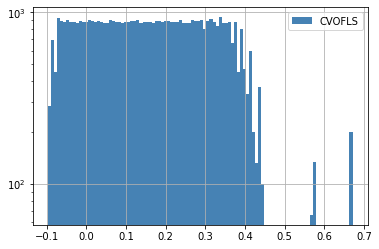

In [81]:
print(output_data.shape)
    
pd.Series(output_data[:, 0]).hist(bins=100, color='steelblue', label='CVOFLS')
ax = plt.gca()
ax.set_yscale('log')
plt.legend()
x1,x2,y1,y2 = plt.axis()
    